## Exploratory Data Analysis

The Labeled Faces in the Wild (LFW) dataset is a benchmark dataset widely used in facial recognition research.

Key Features of the LFW Dataset
1. Purpose:
Designed for face verification tasks, where the goal is to determine whether two images belong to the same person.
Often used for face identification tasks as well.

2. Dataset Composition:
Total Images: 13,233 images.
Number of Individuals: 5,749 individuals.
Number of Images per Person:
Some individuals have many images (e.g., celebrities, public figures), while others have only one.
Images are collected from the web and represent real-world scenarios.
3. Image Details:
Resolution: Varies, but commonly used versions include resized versions (e.g., 64×64 or 128×128).
Color: RGB images.
Format: JPEG.

Number of classes (people): 5749
Total number of images: 13233


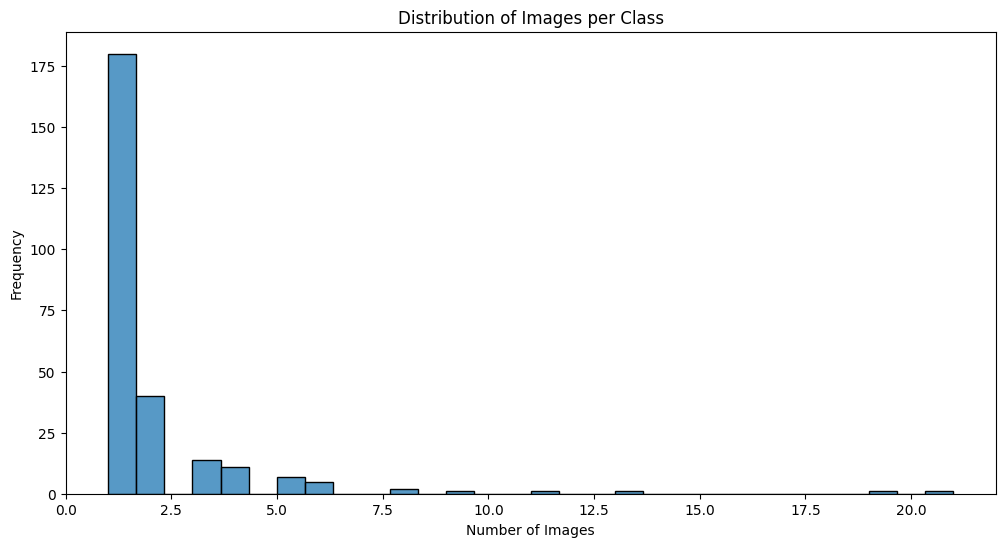

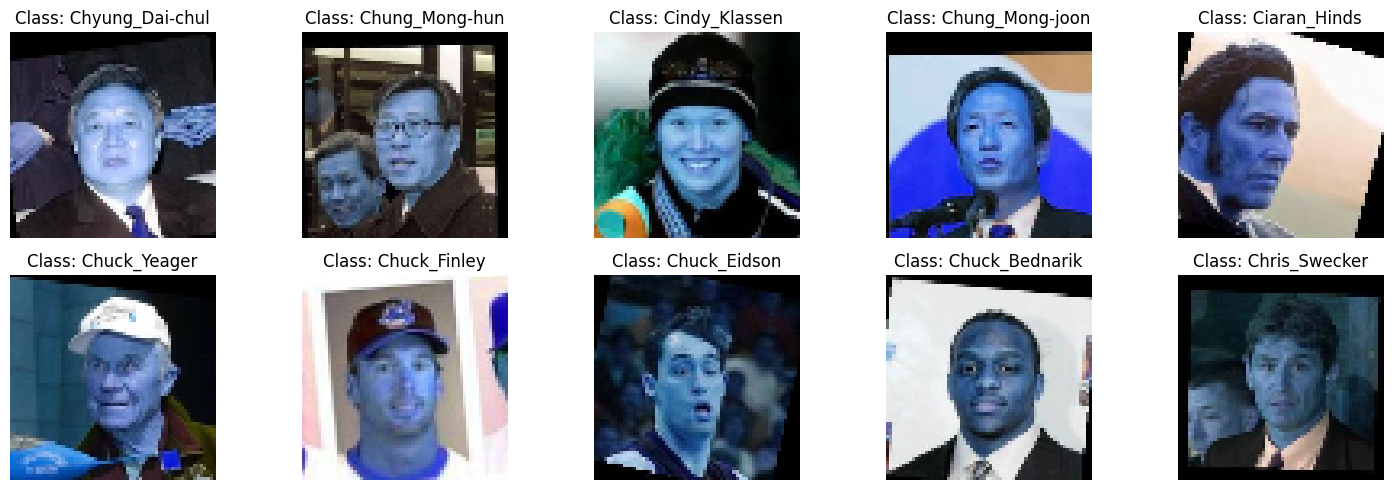

Mean pixel values (RGB): [ 84.10690381  93.78387354 107.78841504]
Std dev of pixel values (RGB): [61.34125413 64.0795567  70.02512706]


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Path to the dataset
dataset_path = "/content/drive/MyDrive/lfw-deepfunneled"
image_size = (64, 64)

# Load dataset structure
def get_dataset_info(dataset_path):
    classes = []
    num_images = 0

    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            classes.append(person)
            num_images += len(os.listdir(person_path))

    return classes, num_images

# Load a subset of images and labels for analysis
def load_images_for_eda(dataset_path, image_size=(64, 64), max_samples=10):
    images, labels = [], []
    label_map = {}
    current_label = 0
    samples_loaded = 0

    for person in os.listdir(dataset_path):
        if samples_loaded >= max_samples:
            break

        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            if person not in label_map:
                label_map[person] = current_label
                current_label += 1
            for img_file in os.listdir(person_path):
                if samples_loaded >= max_samples:
                    break
                img_path = os.path.join(person_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label_map[person])
                    samples_loaded += 1

    return np.array(images), np.array(labels), label_map

# Dataset overview
classes, num_images = get_dataset_info(dataset_path)
print(f"Number of classes (people): {len(classes)}")
print(f"Total number of images: {num_images}")

# Load a sample for EDA
sample_images, sample_labels, label_map = load_images_for_eda(dataset_path, image_size=image_size, max_samples=500)
label_counts = Counter(sample_labels)

# Plot label distribution
plt.figure(figsize=(12, 6))
sns.histplot(list(label_counts.values()), bins=30, kde=False)
plt.title("Distribution of Images per Class")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.show()

# Display a few sample images
def plot_sample_images(images, labels, label_map, num_samples=10):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 5))

    for i in range(min(num_samples, len(unique_labels))):
        sample_idx = np.where(labels == unique_labels[i])[0][0]
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[sample_idx].astype("uint8"))
        plt.title(f"Class: {list(label_map.keys())[unique_labels[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_sample_images(sample_images, sample_labels, label_map)

# Analyze image statistics
def analyze_image_statistics(images):
    means = [np.mean(img, axis=(0, 1)) for img in images]
    std_devs = [np.std(img, axis=(0, 1)) for img in images]

    mean_values = np.mean(means, axis=0)
    std_values = np.mean(std_devs, axis=0)

    print(f"Mean pixel values (RGB): {mean_values}")
    print(f"Std dev of pixel values (RGB): {std_values}")

analyze_image_statistics(sample_images)

## Model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess the dataset
def load_images(dataset_path, image_size=(64, 64)):
    images, labels = [], []
    label_map = {}  # Map class names to integer labels
    current_label = 0

    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            if person not in label_map:
                label_map[person] = current_label
                current_label += 1
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size) / 255.0  # Resize and normalize
                    images.append(img)
                    labels.append(label_map[person])

    return np.array(images), np.array(labels), label_map

# Path to the dataset
dataset_path = "/content/drive/MyDrive/lfw-deepfunneled"
image_size = (64, 64)
images, labels, label_map = load_images(dataset_path, image_size=image_size)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define a simple CNN model
def build_simple_facenet(input_shape=(64, 64, 3), embedding_size=128):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected embedding layer
    embeddings = layers.Dense(embedding_size, activation=None)(x)

    model = Model(inputs, embeddings, name="SimpleFaceNet")
    return model

# Build and compile the model
embedding_size = 128
model = build_simple_facenet(input_shape=(64, 64, 3), embedding_size=embedding_size)
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Add a classification head for training
classification_layer = layers.Dense(len(label_map), activation="softmax", name="classification")(model.output)
classification_model = Model(model.input, classification_layer)

classification_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
epochs = 10
batch_size = 32
history = classification_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Save the base model (without the classification head)
model.save("simple_facenet_model.h5")

# Inference example: Generate embeddings
def get_embeddings(model, images):
    return model.predict(images)

# Example of generating embeddings
sample_images = X_val[:5]
embeddings = get_embeddings(model, sample_images)

# Use embeddings for verification
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

print("Cosine similarity between two samples:")
print(cosine_similarity(embeddings[0], embeddings[1]))


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 118s 350ms/step - accuracy: 0.0400 - loss: 8.3839 - val_accuracy: 0.0419 - val_loss: 8.3538
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 110s 334ms/step - accuracy: 0.0410 - loss: 7.4184 - val_accuracy: 0.0419 - val_loss: 8.8873
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 144s 339ms/step - accuracy: 0.0404 - loss: 7.1407 - val_accuracy: 0.0419 - val_loss: 9.7160
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 140s 333ms/step - accuracy: 0.0412 - loss: 7.1718 - val_accuracy: 0.0419 - val_loss: 8.9300
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 139s 323ms/step - accuracy: 0.0412 - loss: 7.3532 - val_accuracy: 0.0419 - val_loss: 9.4110
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 145s 332ms/step - accuracy: 0.0412 - loss: 7.2905 - val_accuracy: 0.0419 - val_loss: 10.3276
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 105s 317ms/step - accuracy: 0.0412 - loss: 7.1939 - val_accuracy: 0.0419 - val_loss: 10.6199
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 145s 325ms/step - accuracy: 0.0412

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Cosine similarity between two samples:
0.9996721


## Visualization

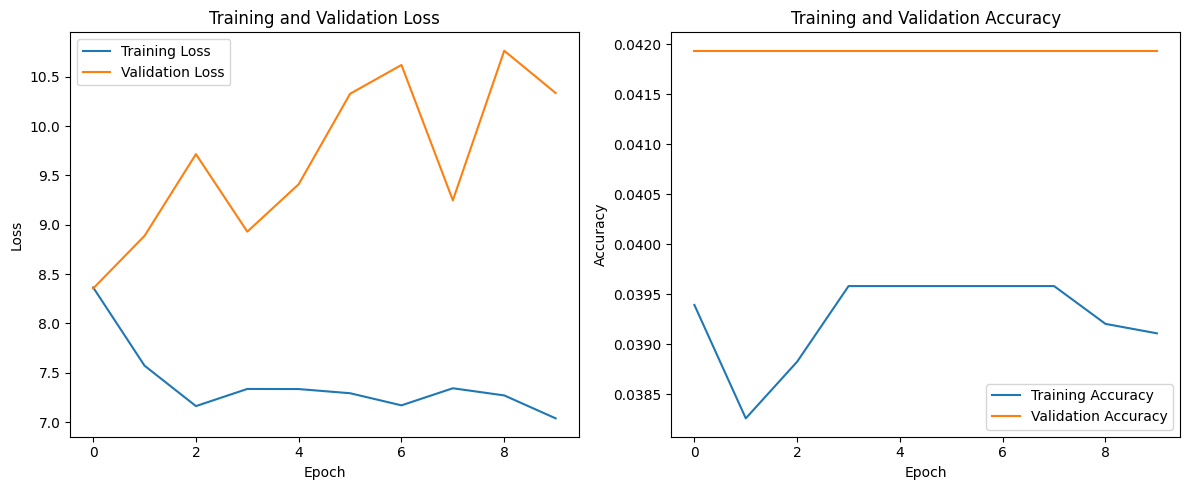

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


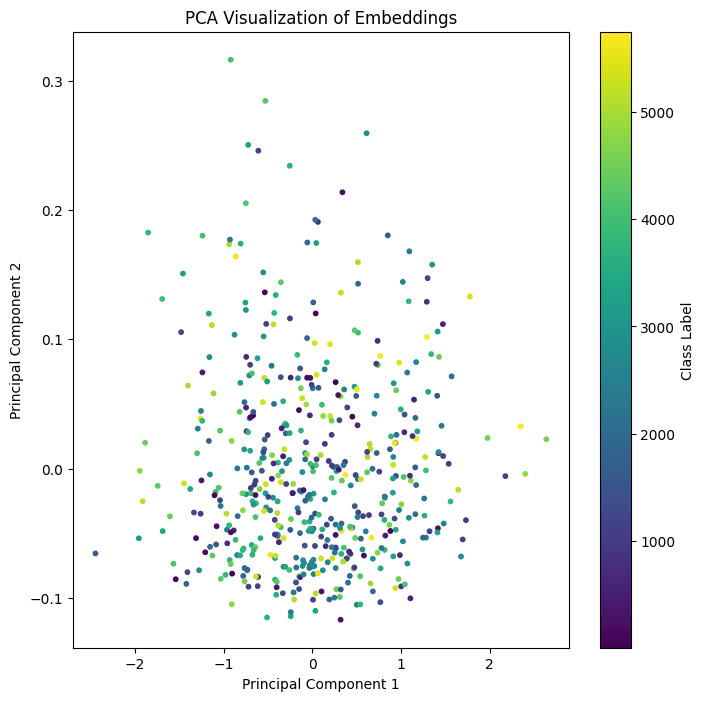

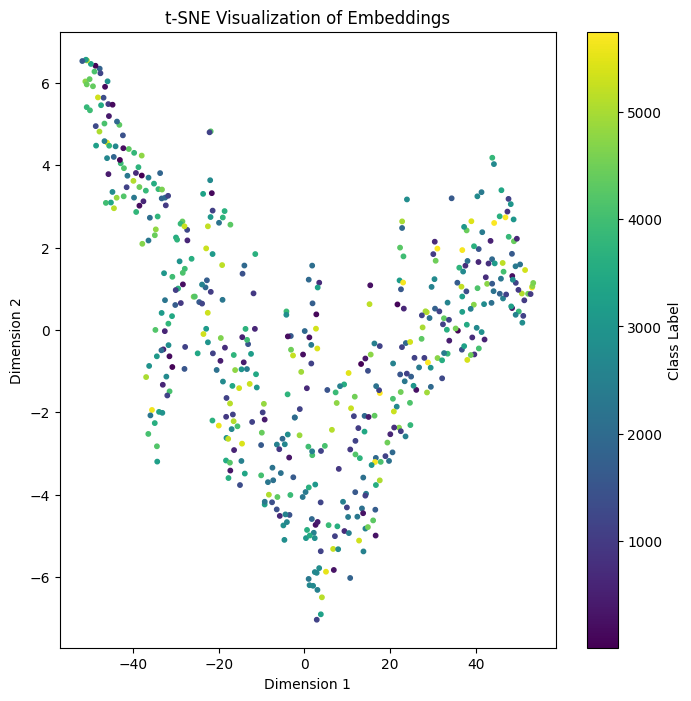

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Plot training and validation loss/accuracy
def plot_training_history(history):
    # Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Visualize embeddings using PCA
def visualize_embeddings_pca(embeddings, labels, label_map):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=10
    )
    plt.colorbar(scatter, label="Class Label")
    plt.title("PCA Visualization of Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Visualize embeddings using t-SNE
def visualize_embeddings_tsne(embeddings, labels, label_map, n_samples=500):
    # Reduce the number of samples for faster visualization
    if len(embeddings) > n_samples:
        embeddings = embeddings[:n_samples]
        labels = labels[:n_samples]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=10
    )
    plt.colorbar(scatter, label="Class Label")
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Generate embeddings for visualization
sample_embeddings = get_embeddings(model, X_val[:500])  # Limit to 500 samples
sample_labels = y_val[:500]

# PCA Visualization
visualize_embeddings_pca(sample_embeddings, sample_labels, label_map)

# t-SNE Visualization
visualize_embeddings_tsne(sample_embeddings, sample_labels, label_map)
